# Installation

First, let's install the dependencies:

I'd reccomend using conda. You might also want to create a new conda environment for this (ie `conda create --name pastis2d python=3.9`... `conda activate pastis2d`)

In [ ]:
%%bash

conda install numpy scipy scikit-learn pandas autograd cython
pip install iced

I suggest you fork (rather than directly clone) [my PASTIS repository](https://github.com/gesinecauer/pastis) so you can easily make your own edits.

After `cd`-ing to your new repo, run this to switch to the `pastis_2d` branch and install PASTIS:

In [ ]:
%%bash

git checkout pastis_2d

module load gcc/8.2.0 gmp/6.1.2 mpfr/4.0.1 mpfr/4.0.1  # Just in case

make cython  # May or may not need to do this
python setup.py develop

If you run into any issuse with installation, please let me know! I am happy to help troubleshoot, and it would be useful for me to know what kinds of issues people might run into with this.

# Simulating data

### How my simulation works

(I wasn't totally sure what kind of simulation would be best for you, so I just kind of made a ton of assumptions... hope the end result is helpful!)

#### Step 1: make 2D structure of non-overlapping beads

I set this up so that all beads must fall within a circle of a given radius. I chose a circle shape rather than a square because the beads that fall near the corners of a square are going to be a lot harder to infer than the other beads.

I also decided to prevent excessive overlap of the beads (though you can turn this feature off by setting `overlap_dist=0`). 

The 2D structure is created by the following process:

1. First, new beads are placed within the circle according to a uniform distribution.
2. Second, any beads that cause overlap are removed. 

These two steps are repeated until the designated number of beads have been simulated.

Here's an example of what the structure will look like:

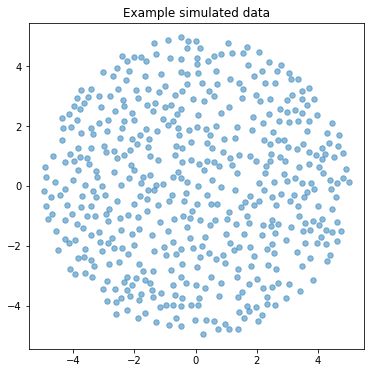

#### Step 2: derive a counts matrix from the structure

**Important note:** the counts matrix is created from the 2D structure via the [same Poisson model used during inference](#how_pastis_works). This means that the simulated data is most suitable for comparing among inference approaches which are all based on the PASTIS Poisson model. If you want to generate counts via a different approach, you can modify the `pastis.simulation.spatial_rnaseq.get_counts` function.

Counts are derived as follows:

1. The simulated structure's distances ($d_{ij}$) are converted to an intermediate value ($\lambda_{ij}$) using the inputted counts-to-distance conversion factor, alpha, as follows: $\lambda_{ij} = \beta d_{ij}^\alpha$. Here, $\beta$ affects read depth, and is determined by the `nreads` argument. Note that alpha must be < 0, since there should be more counts between beads that are closer together.
2. Counts ($c_{ij}$) are drawn from a Poisson distribution of $\lambda_{ij}$

Putting these steps together: $c_{ij} = \mbox{Poisson} \left( \beta d_{ij}^\alpha \right)$

Note: if you want to use the exact value of $\lambda_{ij}$ for the counts, without the Poisson distribution (ie $c_{ij} = \beta d_{ij}^\alpha$), then set `distrib="none"` during simulation. This will result in floating-point values for the counts instead of integers.

### Documentation

Type `sim_spatial_rnaseq --help` for information on the various arguments.

#### Files created by the simulation:
- `struct_true.coords`
    + The 2D simulated structure
- `counts.matrix`
    + Counts that were derived from the simulated structure.
    + Counts are written in the "hiclib" format, and the best way to load them is with the `iced.io.load_counts` function.
- `dataset_info.txt`
    + Contains various info about the simulated structure... number of reads, simulation seed, alpha used in simulation, number of beads (see "lengths"), beta (which you'll want to input to inference, see below), etc.
- `counts.bed`
    + You can ignore this, it's for Hi-C data.

### Python API & plotting example

In [ ]:
from pastis.simulation.spatial_rnaseq import sim_spatial_rnaseq
from iced.io import load_counts
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Simulate datasets
outdir="../results/sim/sim.datasets.2d"  # Edit me
num_struct = 2  # Number of unique datasets to generate (starting with specified seed)
seed = 0  # Random seed
directories_created = sim_spatial_rnaseq(
    nreads=1e5, nbeads=500, num_struct=num_struct, seed=seed, directory=outdir, alpha=-1,
    circle_radius=5, overlap_dist=0.2, distrib='poisson', redo=False, verbose=True)

# Plot
seeds = np.arange(seed, seed + num_struct)
for i in range(num_struct):
    struct_true = np.loadtxt(os.path.join(
        directories_created[i], "struct_true.coords"))
    fig, ax = plt.subplots(1, 2, subplot_kw={'aspect': 'equal'})
    ax[0].scatter(struct_true[:, 0], struct_true[:, 1], alpha=0.5, s=5)
    fig.suptitle(f"Simulation {seeds[i]:03d}")
    
    counts = load_counts(os.path.join(
        directories_created[i], "counts.matrix"), base=0).toarray()
    counts += counts.T
    norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=counts.max(), base=np.e)
    im = ax[1].matshow(
        counts, norm=norm, origin="upper", cmap='Blues',
        extent=(0, counts.shape[1], counts.shape[0], 0))
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='4.6%', pad=0.04)
    myformat = mpl.ticker.FuncFormatter(lambda x, p: '{:.2g}'.format(x).replace(
        '+0', '').replace('+', '').replace('0.0e0', '0'))
    cbar = fig.colorbar(im, cax=cax, format=myformat)
    cbar.locator = mpl.ticker.MaxNLocator(nbins=3)
    cbar.update_ticks()

### Command-line API example

In [ ]:
%%bash

outdir="../results/sim/sim.datasets.2d"  # Edit me

sim_spatial_rnaseq --nreads 1e5 --nbeads 500 --num_struct 1 --seed 0 \
--directory "$outdir" --alpha -1 --circle_radius 5 --overlap_dist 0.2 \
--distrib poisson --verbose

# Running 2D-PASTIS

### Very brief overview of how PASTIS works

<a id='how_pastis_works'></a>

PASTIS models the counts between $i$ and $j$ as a random independent Poisson variable, where the intensity of the Poisson distribution is a decreasing function $f$ of the Euclidean distance between the two beads ($d_{ij}$). This function relates between counts and distances.

PASTIS sets this function as follows: $f(d_{ij}) \sim d_{ij}^\alpha$, $\alpha < 0$. The $\alpha$ parameter can be set using prior knowledge (e.g., $\alpha = -1$), or inferred jointly with the 3D structure.

As PASTIS was originally designed to infer 3D chromatin structures from Hi-C data, this function was derived from the biophysical properties of DNA as a polymer. It's possible a different function would be more suitable for relating between counts and distances in spatial transcriptomics data. However, I assume that there is an inverse relationship between counts and distances in this data as well, so $d_{ij}^\alpha$ is probably a decent starting point, especially when alpha is inferred.


Inference is performed by maximizing the likelihood of the following Poisson model:

$$c_{ij} \sim \mbox{Poisson}\left( \beta d_{ij}^{\alpha} \right)$$
where $\beta$ is a scaling parameter that determines the size of the structure, relative to the read depth of the counts matrix (you don't need to worry about beta unless you're inferring structures from my simulated data, see below).

Please refer to [the original 2014 PASTIS paper](https://academic.oup.com/bioinformatics/article/30/12/i26/385087) for more details.

### Documentation

You can quickly pull up the arguments via `pastis-poisson --help`, but I copied them below for convenience and to add some extra notes.

These arguments can be inputted into the `pastis.optimization.pastis_algorithms.pastis_poisson` python function or the `pastis-poisson` script on the command line.


#### The important stuff:
- `counts`: Counts data files in the hiclib format or as numpy ndarrays.
- `lengths`: In your case, set this to the total number of beads.
- `seed`: Random seed used when generating the starting point in the optimization.
- `outdir`: Directory in which to save results.
- `alpha`: Biophysical parameter of the transfer function used in converting counts to wish distances. If alpha is not specified, it will be inferred jointly alongside the structure via a coordinate descent approach (first inferring a structure with fixed alpha, then alpha with fixed structure, etc).
    + I'd reccomend first inferring structures with a fixed alpha (to make sure it converges properly and nothing weird happens), then trying to infer alpha.


#### When inferring alpha:
- `alpha_init`: When inferring alpha, this is the initial value of alpha to use. (default = -1).
- `max_alpha_loop`: When inferring alpha, this is the maximum number of cycles in which PASTIS will infer the alpha (with a fixed structure) and then the structure (with a fixed alpha). (default=20)


#### Some options you can play around with if interested:
- `init`: By default, the program first infers a structure via multi-dimensional scaling (MDS), then inputs that structure into the main inference step with the PASTIS loss function. You can skip the MDS step though, and go straight from the random initialization to inferring with the PASTIS loss function. To do so, use `init="random"`.
    + The MDS loss function minimizes the mean squared error between the inferred distances between beads $\left( d_{ij} \right)$ and what we expect the distances to be, based on the counts matrix $\left( c_{ij}^{\frac{1}{\alpha}} \right)$. Note that $\alpha$ is not inferred during MDS (if a predetermined `alpha` is not set, `alpha_init` is used as the $\alpha$ for MDS)
- `exclude_zeros`: Sometimes some of the counts matrix bins contain zero counts. By default, these bins are still included in optimzation, and we've generally found that excluding them worsens results. However, it is possible to exclude the empty bins if you want to try it out yourself.


#### Convergence criteria:
You almost definitely won't have to touch these!
- `max_iter`: Maximum number of iterations per optimization.
    + In the highly unlikely event that you run into convergence due to exceeding the max number of iterations, you can increase this.
- `factr`: factr for [scipy's L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html), alters convergence criteria
- `pgtol`: pgtol for [scipy's L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html), alters convergence criteria
- `alpha_factr`: factr for convergence criteria of joint alpha/structure inference


#### When inferring my 2D simulated data:
- `beta`: Scaling parameter that determines the size of the structure, relative to the read depth of the counts matrix. If None, an arbitrary beta will be chosen.
    + Beta is meaningless when inferring structures from real experimental data because the size of the final structure is all relative anyways.
    + However, when inferring structures from my 2D simulated data, setting beta allows you to infer structures that are exactly the same size as the simulated structure, which makes it easier to compare between the simulated and inferred structures when analyzing results.
   
#### Files created by the inference:
- `struct_inferred.*.coords`
    + The final 2D inferred structure for the given random seed
- `history.*`
    + Information collected during the optimization process (ie iteration, current time, current value of the objective, etc)
- `inference_variables.*`
    + Information collected at the end of optimization, including final objective, final value of alpha, and whether the inference converged. 

### Command-line API examples

#### Ex 1: Inferring with predetermined alpha = -1
This is the same as the true alpha used in simulation

In [ ]:
%%bash

counts_dir="../results/sim/sim.datasets.2d/sim_spatial_rnaseq.nbeads500_alpha-1_circle5_overlap0.2_poisson_nreads100000/000"  # Edit me
infer_dir="$counts_dir/infer.alpha-1"
seed=0

pastis-poisson --counts "$counts_dir/counts.matrix" --lengths 500 --seed "$seed" --outdir "$infer_dir" \
--alpha -1 --beta $(awk -F "\t" '$1 == "beta" {print $2}'  "$counts_dir/dataset_info.txt")

#### Ex 2: Inferring with predetermined alpha = -2
The true alpha is -1, so we are now inferring with an incorrect alpha

In [ ]:
%%bash

counts_dir="../results/sim/sim.datasets.2d/sim_spatial_rnaseq.nbeads500_alpha-1_circle5_overlap0.2_poisson_nreads100000/000"  # Edit me
infer_dir="$counts_dir/infer.alpha-2"
seed=0

pastis-poisson --counts "$counts_dir/counts.matrix" --lengths 500 --seed "$seed" --outdir "$infer_dir" \
--alpha -2 --beta $(awk -F "\t" '$1 == "beta" {print $2}'  "$counts_dir/dataset_info.txt")

#### Ex 3: Inferring alpha jointly alongside the structure
Using an initial guess of -2 for alpha

In [ ]:
%%bash

counts_dir="../results/sim/sim.datasets.2d/sim_spatial_rnaseq.nbeads500_alpha-1_circle5_overlap0.2_poisson_nreads100000/000"  # Edit me
infer_dir="$counts_dir/infer.alpha_init-2"
seed=0

pastis-poisson --counts "$counts_dir/counts.matrix" --lengths 500 --seed "$seed" --outdir "$infer_dir" \
--alpha_init -2 --beta $(awk -F "\t" '$1 == "beta" {print $2}'  "$counts_dir/dataset_info.txt")

# Analyzing results

## To rescale or not to rescale?

If the inferred structure is not the same size as the true structure, it is generally best to optimally rescale the inferred structure such that it matches the true structure. (Rescaling is done by minimizing the differences between the true & inferred structures, [see below](#error_scores)).

Your inferred structure will be *not* be the same size of the true structure in the following two cases:

- When structures are inferred without `beta` beting set to the true value of beta from the simulation.
- When simulated counts are derived from the simulated true structure via a method different from what I've described above, such that there is not "true value of beta".

## Quantifying accuracy

### Our structure similarity scores

<a id='error_scores'></a>

#### RMSD
Root mean square deviation (RMSD) is a common way of comparing the coordinates of two structures: $\mathbf{X}$, $\mathbf{X}' \in R^{2 \times m}$. RMSD is defined as
$$RMSD = \min_{X^{*}} \sqrt{\frac{\sum_{i} (\mathbf{X}_i -\mathbf{X}_i^{*})^{2}}{m}}\,\,,$$
where  $\mathbf{X}^{*}$ is obtained by optimally translating, rotating, and rescaling $\mathbf{X}'$ (the rescaling is optional, as discussed above).


#### Distance Error
Distance Error is the root mean squared error of the distance matrices. It assigns more weight to long distances than RMSD. It is defined as
$$distError = \min_{X^{*}} \sqrt{\frac{\sum_{i, j} (d_{ij}(\mathbf{X}) - d_{ij}(\mathbf{X}^{*}))^{2}}{m}},$$
where structure $\mathbf{X}^{*}$ is obtained by optimally rescaling $\mathbf{X}'$ (the rescaling is optional, as discussed above).


#### What do these scores mean?
For both RMSD and Distance Error, lower scores = higher similarity between structures = more accurate inference. 

These error scores are most useful in comparing between inference approaches. Unfortunately, they don't tell you how low of a score is "good enough".

### Documentation

Type `get_error_scores --help` for information on the various arguments.

Note that you can input multiple inferred structures at once, as long as they all correspond to the same true structure (ie if inferring multiple times from the same dataset, using different random seeds).

In general, when comparing between inference approaches, I like to run inference on 10-20 separate datasets, and for each dataset I infer with 5 different random seeds. This leads to a more robust comparison.

(Note that the `struct_null` option is currently not relevant to you, since you don't have any constraints -- just the Poisson objective.)

If you prefer a python API, use the `pastis.validation.error_scores.get_error_scores` function.

### Command-line API example:

In [ ]:
%%bash

counts_dir="../results/sim/sim.datasets.2d/sim_spatial_rnaseq.nbeads500_alpha-1_circle5_overlap0.2_poisson_nreads100000/000"  # Edit me
seed=0

infer_dir_ex1="$counts_dir/infer.alpha-1"
infer_dir_ex2="$counts_dir/infer.alpha-2"
infer_dir_ex3="$counts_dir/infer.alpha_init-2"

echo "==== Predetermined alpha = -1 ===="
get_error_scores --true "$counts_dir/struct_true.coords" \
--infer "$infer_dir_ex1/struct_inferred.00$seed.coords" --verbose

echo -e "\n\n==== Predetermined alpha = -2 ===="
get_error_scores --true "$counts_dir/struct_true.coords" \
--infer "$infer_dir_ex2/struct_inferred.00$seed.coords" --verbose

echo -e "\n\n==== Alpha inferred jointly alongside structure ===="
get_error_scores --true "$counts_dir/struct_true.coords" \
--infer "$infer_dir_ex3/struct_inferred.00$seed.coords" --verbose

## Visualization

Sometimes it can also be helpful to visually compare the true and inferred structure.

### Example: visualizing inference results in python

In [ ]:
from pastis.validation._realignment import realign_structures
import numpy as np
import os
from matplotlib import pyplot as plt
import os
import math
import colorsys


def get_colors(struct_true):
    x = struct_true[:, 0]
    y = struct_true[:, 1]
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x) + np.pi
    tmp2 = r / r.max()
    tmp1 = theta / 2 / np.pi
    colors = np.array([
        colorsys.hsv_to_rgb(h=tmp1[i], s=1, v=tmp2[i]) for i in range(x.size)])
    return colors


def compare_structure(counts_dir, infer_dir, seed, rescale=False, title=None):
    struct_true = np.loadtxt(os.path.join(counts_dir, "struct_true.coords"))[:, :2]
    struct_infer = np.loadtxt(os.path.join(infer_dir, f"struct_inferred.{seed:03d}.coords"))[:, :2]

    colors = get_colors(struct_true)

    # Realign inferred structure to match orientation of true structure
    struct_infer_realign, rmsd = realign_structures(
        X=struct_infer, Y=struct_true, rescale_X_to_Y=rescale, error_type='rmsd')

    plt.figure(figsize=(10, 10))
    plt.scatter(struct_true[:, 0], struct_true[:, 1], s=40, c=colors, alpha=0.5, label="True")
    plt.scatter(struct_infer_realign[:, 0], struct_infer_realign[:, 1], s=40, c=colors, alpha=0.5, marker='s', label="Inferred")
    for i in range(struct_true.shape[0]):
        plt.plot([struct_true[i, 0], struct_infer_realign[i, 0]], [struct_true[i, 1], struct_infer_realign[i, 1]], alpha=0.4, marker=None, c='black')
    _ = plt.legend()
    if title is None:
        title = f'RMSD = {rmsd:.3g}'
    else:
        title = f'{title}\nRMSD = {rmsd:.3g}'
    plt.title(title)


counts_dir = "../results/sim/sim.datasets.2d/sim_spatial_rnaseq.nbeads500_alpha-1_circle5_overlap0.2_poisson_nreads100000/000"  # Edit me
infer_dir_ex1 = os.path.join(counts_dir, "infer.alpha-1")
infer_dir_ex2 = os.path.join(counts_dir, "infer.alpha-2")
infer_dir_ex3 = os.path.join(counts_dir, "infer.alpha_init-2")
seed = 0

compare_structure(
    counts_dir=counts_dir, infer_dir=infer_dir_ex1, seed=seed, rescale=False,
    title="True alpha = -1\nInferred with alpha = -1")

compare_structure(
    counts_dir=counts_dir, infer_dir=infer_dir_ex2, seed=seed, rescale=False,
    title="True alpha = -1\nInferred with alpha = -2")

compare_structure(
    counts_dir=counts_dir, infer_dir=infer_dir_ex3, seed=seed, rescale=False,
    title="True alpha = -1\nInferring alpha (initial guess = -2)")